In [1]:
import tidy3d.web as web # if needed
web.test()

[14:24:02] Authentication configured successfully!                                                    ]8;id=343428;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=491254;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#740\740]8;;\

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
import tidy3d.web as web 
from tidy3d.plugins.mode import ModeSolver
import gdstk

In [3]:
# VS Code has an existing "outline" feature for code editing. #This feature is being reused in notebooks for holding ToC navigation. On your left side panel it's "> Outline" below your open files. It should populate with markdown headings and be able to navigate to them. Like so:

In [4]:
from platform import python_version

print(python_version())


3.10.11


# Simulation Setup

In [3]:
w0 = 0.54  # width of the input/output single mode waveguides
w1 = 0.69  # width of the first tapper
w2 = 0.83  # width of the second tapper
w3 = 0.9  # width of the third tapper
w4 = 0.405  # width of the narrow waveguide
w_gap = 0.15  # gap of the directional coupler
L_tp1 = 4  # length of the first tapper
L_tp2 = 44  # length of the second tapper
L_tp3 = L_tp1 * (w3 - w2) / (w1 - w0)  # length of the third tapper
L_dc = 7  # length of the directional coupler
L_tpout = 14  # length of the output tapper
shift = 0.4  # shift of the narrow waveguide output
h_co = 0.22  # thickness of the waveguides
inf_eff = 1000  # effective infinity used to make sure the waveguides extend into pml

## Define materials

In [4]:
si = td.Medium(permittivity=3.455**2)
sio2 = td.Medium(permittivity=1.445**2)
si3n4 = td.Medium(permittivity=2**2)

## define structure

In [5]:
cladding = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -inf_eff, -h_co / 2), rmax=(inf_eff, inf_eff, inf_eff)
    ),
    medium=si3n4,
)

vertices = np.array(
    [
        (-w0 / 2, -inf_eff),
        (-w0 / 2, 0),
        (-w1 / 2, L_tp1),
        (-w2 / 2, L_tp1 + L_tp2),
        (-w3 / 2, L_tp1 + L_tp2 + L_tp3),
        (-w3 / 2, L_tp1 + L_tp2 + L_tp3 + L_dc),
        (-w0 / 2, L_tp1 + L_tp2 + L_tp3 + L_dc + L_tpout),
        (-w0 / 2, inf_eff),
        (w0 / 2, inf_eff),
        (w0 / 2, L_tp1 + L_tp2 + L_tp3 + L_dc + L_tpout),
        (w3 / 2, L_tp1 + L_tp2 + L_tp3 + L_dc),
        (w3 / 2, L_tp1 + L_tp2 + L_tp3),
        (w2 / 2, L_tp1 + L_tp2),
        (w1 / 2, L_tp1),
        (w0 / 2, 0),
        (w0 / 2, -inf_eff),
    ]
)

wide_wg = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(-h_co / 2, h_co / 2)),
    medium=si,
)

R = 100
cell = gdstk.Cell("bend")  # define a gds cell
bend = gdstk.FlexPath((-w3 / 2 - w_gap - w4 / 2, L_tp1 + L_tp2 + L_tp3), w4, layer=1, datatype=0)
bend.vertical(L_dc, relative=True)
bend.arc(R, 0, np.pi / 50)
bend.arc(R, -np.pi + np.pi / 50, -np.pi)
bend.vertical(inf_eff)
cell.add(bend)

# define the waveguide bend tidy3d geometries
bend_geo = td.PolySlab.from_gds(
    cell,
    gds_layer=1,
    axis=2,
    slab_bounds=(-h_co / 2, h_co / 2),
)[0]

narrow_wg = td.Structure(geometry=bend_geo, medium=si)

## Set up mode source and monitors;visualization

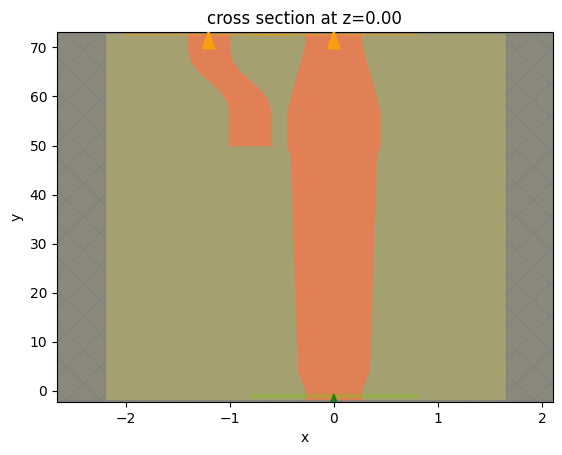

In [6]:
lda0 = 1.525  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.45, 1.6, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range

# buffer lengths in x and y directions
buffer_x = 1
buffer_y = 2

# simulation domain size
Lx = w3 + w_gap + w4 + shift + 2 * buffer_x
Ly = L_tp1 + L_tp2 + L_tp3 + L_dc + L_tpout + 2 * buffer_y
Lz = 10 * h_co
sim_size = (Lx, Ly, Lz)

# define mode source that launches the TE0 mode (mode_index=0). Later, we will modify it to investigate the TM0 mode case
mode_spec = td.ModeSpec(num_modes=2, target_neff=3)
mode_source = td.ModeSource(
    center=(0, -buffer_y / 2, 0),
    size=(3 * w0, 0, 5 * h_co),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,  #TE0 mode
)

# define a field monitor
field_monitor = td.FieldMonitor(
    center=(0, -buffer_y / 2, 0), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

# define two flux monitors at the two outputs to measure transmission
flux_monitor1 = td.FluxMonitor(
    center=(0, Ly - buffer_y, 0), size=(3 * w0, 0, 5 * h_co), freqs=freqs, name="flux1"
)

flux_monitor2 = td.FluxMonitor(
    center=(-w4 / 2 - w3 / 2 - w_gap - shift, Ly - buffer_y, 0),
    size=(3 * w0, 0, 5 * h_co),
    freqs=freqs,
    name="flux2",
)

# define two mode monitors at the two outputs to study output polarization
mode_monitor1 = td.ModeMonitor(
    center=(0, Ly - buffer_y, 0),
    size=(3 * w0, 0, 5 * h_co),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode1",
)

mode_monitor2 = td.ModeMonitor(
    center=(-w4 / 2 - w3 / 2 - w_gap - shift, Ly - buffer_y, 0),
    size=(3 * w0, 0, 5 * h_co),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode2",
)

# initialize the Simulation object
sim = td.Simulation(
    center=(-(shift + w_gap) / 2, Ly / 2 - buffer_y, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
    structures=[cladding, wide_wg, narrow_wg],
    sources=[mode_source],
    monitors=[
        field_monitor,
        flux_monitor1,
        flux_monitor2,
        mode_monitor1,
        mode_monitor2,
    ],
    run_time=2e-12,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=sio2,
)

# plot the simulation at z=0 to inspect the structure, source, and monitors
fig = plt.figure()
ax = fig.add_subplot(111)
sim.plot(z=0, ax=ax)
ax.set_aspect("auto")

## visualize TE0 TM0

In [7]:
mode_solver = ModeSolver(
    simulation=sim,
    plane=td.Box(center=(0, -buffer_y / 2, 0), size=(2 * w0, 0, 5 * h_co)),
    mode_spec=mode_spec,
    freqs=[freq0],
)
mode_data = mode_solver.solve()

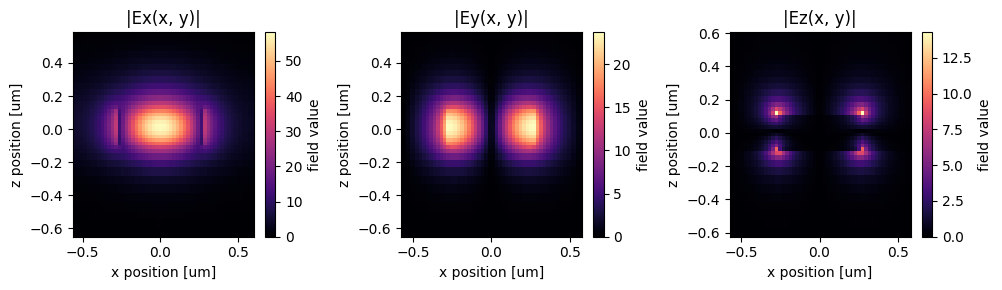

In [8]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3))
abs(mode_data.Ex.isel(mode_index=0)).plot(x="x", y="z", ax=ax1, cmap="magma")
abs(mode_data.Ey.isel(mode_index=0)).plot(x="x", y="z", ax=ax2, cmap="magma")
abs(mode_data.Ez.isel(mode_index=0)).plot(x="x", y="z", ax=ax3, cmap="magma")

ax1.set_title("|Ex(x, y)|")
ax2.set_title("|Ey(x, y)|")
ax3.set_title("|Ez(x, y)|")
plt.show()

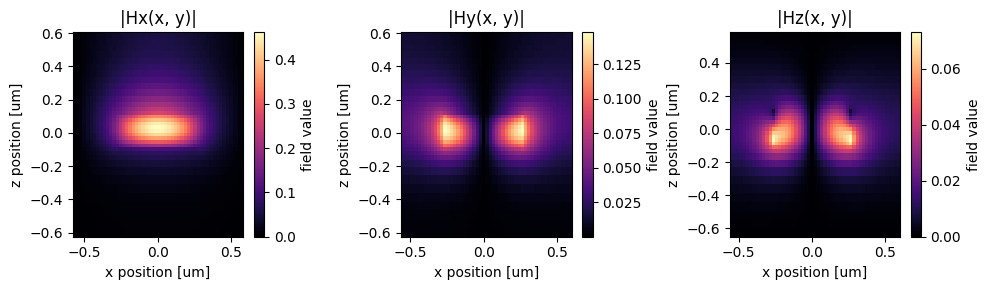

In [11]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3))
abs(mode_data.Hx.isel(mode_index=1)).plot(x="x", y="z", ax=ax1, cmap="magma")
abs(mode_data.Hy.isel(mode_index=1)).plot(x="x", y="z", ax=ax2, cmap="magma")
abs(mode_data.Hz.isel(mode_index=1)).plot(x="x", y="z", ax=ax3, cmap="magma")

ax1.set_title("|Hx(x, y)|")
ax2.set_title("|Hy(x, y)|")
ax3.set_title("|Hz(x, y)|")
plt.show()

# Submit the simulation to the server

In [12]:
job = web.Job(simulation=sim, task_name="polarization_splitter_rotator", verbose=True)
sim_data = job.run(path="data/simulation_data.hdf5")

[15:49:16] Created task 'polarization_splitter_rotator' with task_id                                  ]8;id=847378;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=720793;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#186\186]8;;\
           'fdve-f4ac3226-531d-43a9-a11d-342e6b755313v1'.                                                          

           View task using web UI at                                                                  ]8;id=688435;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=69767;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#188\188]8;;\
           ]8;id=260114;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4ac3226-531d-43a9-a11d-342e6b755313v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=903042;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4ac3226-531d-43a9-a11d-342e6b755313v1\taskId]8;;\]8;id=260114;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4ac3226-531d-43a9-a11d-342e6b755313v1\=]8;;\]8;id=638310;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4ac3226-531d-43a9-a11d-342e6b755313v1\fdve]8;;\]8;id=260114;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4ac3226-531d-43a9-a11d-342e6b755313v1\-f4ac3226-531d-43a9-a11d-342e6b75531]8;;\              
           ]8;id=260114;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f4ac3226-531d-43a9-a11d-342e6b755313v1\3v1']8;;\.                                                                                                   

Output()

[15:49:18] status = queued                                                                            ]8;id=653638;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=142460;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#321\321]8;;\

Output()

[15:49:20] status = preprocess                                                                        ]8;id=908536;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=95245;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#315\315]8;;\

[15:49:27] Maximum FlexCredit cost: 0.692. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=372797;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=242920;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#338\338]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=397795;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=103630;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#342\342]8;;\

           running solver                                                                             ]8;id=204080;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=316791;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#352\352]8;;\

Output()

[15:51:48] early shutoff detected, exiting.                                                           ]8;id=786094;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=404424;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#366\366]8;;\

           status = postprocess                                                                       ]8;id=820287;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=674126;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#383\383]8;;\

Output()

[15:52:10] status = success                                                                           ]8;id=513146;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=700345;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#390\390]8;;\

Output()

[15:52:11] loading SimulationData from data/simulation_data.hdf5                                      ]8;id=810015;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=413681;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#568\568]8;;\

# Visualize the results of the case when TE0 Mode at the Input

## field distribution

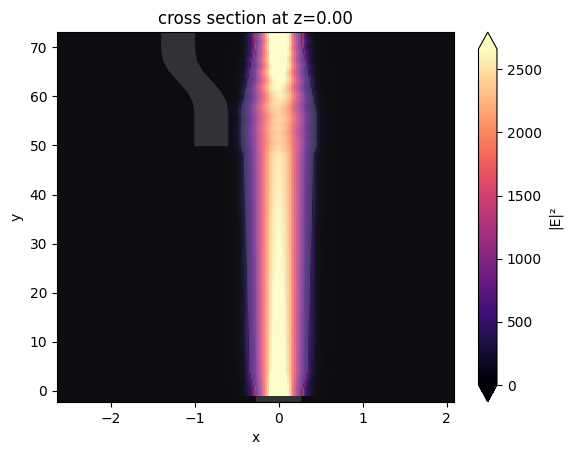

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
sim_data.plot_field(field_monitor_name="field", field_name="E", val="abs^2", ax=ax, f=freq0)
ax.set_aspect("auto")

## transmission spectrum

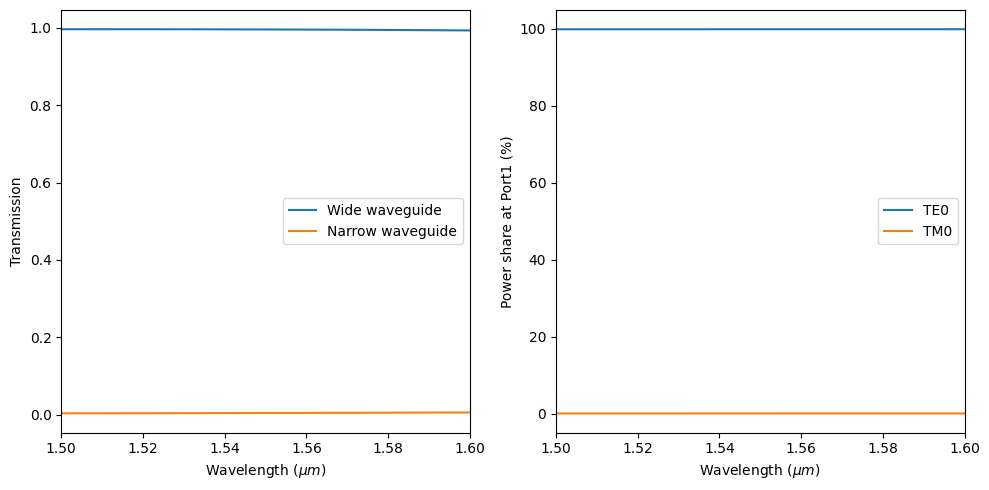

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5))
T1 = sim_data["flux1"].flux
T2 = sim_data["flux2"].flux

plt.sca(ax1)
plt.plot(ldas, T1, ldas, T2)
plt.xlim(1.5, 1.6)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Transmission")
plt.legend(("Wide waveguide", "Narrow waveguide"))

plt.sca(ax2)
mode_amp = sim_data["mode1"].amps.sel(direction="+")
mode_power_share = 100 * np.abs(mode_amp) ** 2 / T1
plt.plot(ldas, mode_power_share)
plt.xlim(1.5, 1.6)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Power share at Port1 (%)")
plt.legend(["TE0", "TM0"])
plt.show()

# Launching the TM0 Mode at the Input; run 

In [15]:
mode_source = mode_source.copy(update={"mode_index": 1})  # mode_index=1 corresponds to the TM0 mode

sim = sim.copy(update={"sources": [mode_source]})
job = web.Job(simulation=sim, task_name="polarization_splitter_rotator", verbose=True)
sim_data = job.run(path="data/simulation_data.hdf5")

[15:52:14] Created task 'polarization_splitter_rotator' with task_id                                  ]8;id=215552;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=397945;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#186\186]8;;\
           'fdve-e47ada33-f206-4fc6-85d7-26dfdec19c90v1'.                                                          

           View task using web UI at                                                                  ]8;id=337924;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=965737;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#188\188]8;;\
           ]8;id=532282;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e47ada33-f206-4fc6-85d7-26dfdec19c90v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=132337;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e47ada33-f206-4fc6-85d7-26dfdec19c90v1\taskId]8;;\]8;id=532282;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e47ada33-f206-4fc6-85d7-26dfdec19c90v1\=]8;;\]8;id=454382;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e47ada33-f206-4fc6-85d7-26dfdec19c90v1\fdve]8;;\]8;id=532282;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e47ada33-f206-4fc6-85d7-26dfdec19c90v1\-e47ada33-f206-4fc6-85d7-26dfdec19c9]8;;\              
           ]8;id=532282;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e47ada33-f206-4fc6-85d7-26dfdec19c90v1\0v1']8;;\.                                                                                                   

Output()

[15:52:15] status = queued                                                                            ]8;id=193611;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=587049;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#321\321]8;;\

Output()

[15:52:18] status = preprocess                                                                        ]8;id=199851;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=971522;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#315\315]8;;\

[15:52:25] Maximum FlexCredit cost: 0.692. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=750034;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=569878;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#338\338]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=41879;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=772985;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#342\342]8;;\

           running solver                                                                             ]8;id=153756;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=309163;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#352\352]8;;\

Output()

[15:55:59] early shutoff detected, exiting.                                                           ]8;id=866457;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=236799;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#366\366]8;;\

           status = postprocess                                                                       ]8;id=277495;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=558912;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#383\383]8;;\

Output()

[15:56:22] status = success                                                                           ]8;id=241921;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=525372;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#390\390]8;;\

Output()

[15:56:29] loading SimulationData from data/simulation_data.hdf5                                      ]8;id=550358;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=784874;file:///Users/qwang/.pyenv/versions/3.10.11/envs/env_tidy3d/lib/python3.10/site-packages/tidy3d/web/webapi.py#568\568]8;;\

# visualize the result of TM0 as input

## field distribution

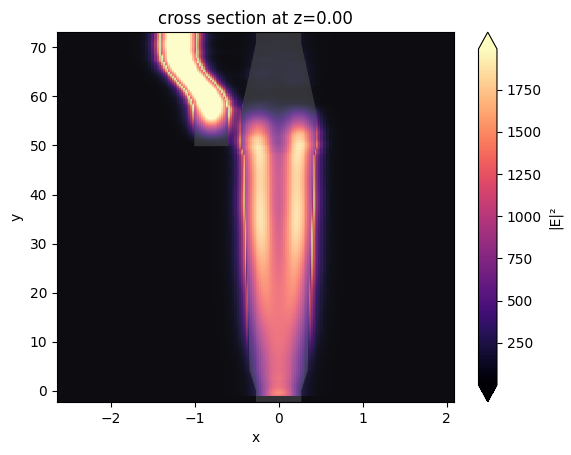

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
sim_data.plot_field(field_monitor_name="field", field_name="E", val="abs^2", ax=ax, f=freq0)
ax.set_aspect("auto")

## transmission spectrum

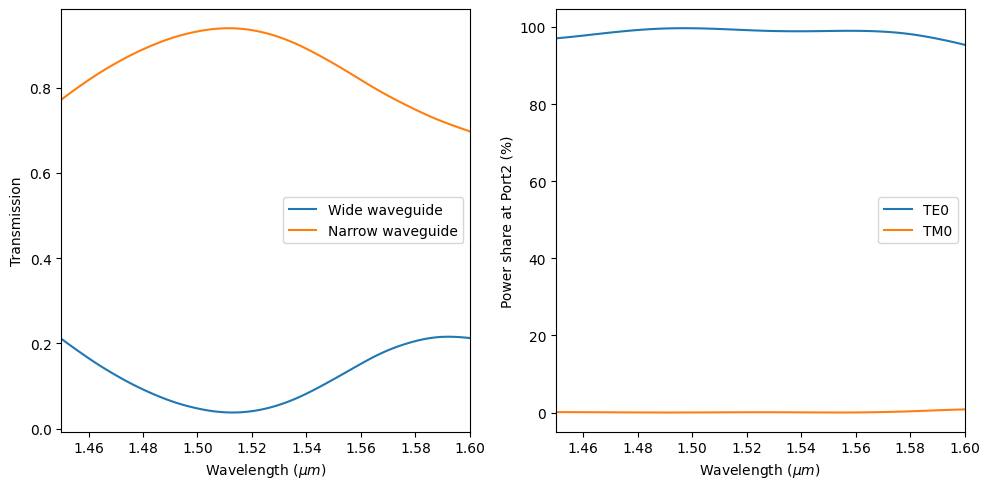

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5))
T1 = sim_data["flux1"].flux
T2 = sim_data["flux2"].flux

plt.sca(ax1)
plt.plot(ldas, T1, ldas, T2)
plt.xlim(1.45, 1.6)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Transmission")
plt.legend(("Wide waveguide", "Narrow waveguide"))

plt.sca(ax2)
mode_amp = sim_data["mode2"].amps.sel(direction="+")
mode_power_share = 100 * np.abs(mode_amp) ** 2 / T2
plt.plot(ldas, mode_power_share)
plt.xlim(1.45, 1.6)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Power share at Port2 (%)")
plt.legend(["TE0", "TM0"])
plt.show()